In [1]:


# =============================================================================
# ========================      EXPLANATION       =============================
# This script trains an MLP model on the Stanford Dogs dataset using a selected 
# hyperparameter configuration from a predefined grid search space.
#
# - The model is trained according to the configuration defined by SELECTED_ID.
# - To train your own configuration, simply change the value of SELECTED_ID.
# - The model will automatically train using the corresponding hyperparameters.
# - The best validation accuracy and its epoch will be computed after training.
# - All training results are automatically saved to:
#       results/results.csv
# - The list of all available configurations is saved to:
#       results/config_list.csv
#
# Each team member should update SELECTED_ID with their assigned configuration ID,
# run the code, and share the generated results.csv file for aggregation.
# =============================================================================




# ==========================================
# GEREKLİ PAKETLERİN OTOMATİK KURULUMU
# AUTOMATIC INSTALLATION OF NECESSARY PACKAGES
# ==========================================

import subprocess
import sys

required_packages = [
    "tensorflow",
    "numpy",
    "matplotlib",
    "scipy"
]

def install_if_missing(package):
    try:
        __import__(package)
        print(f"'{package}' zaten yüklü.")
    except ImportError:
        print(f"'{package}' bulunamadı. Kuruluyor...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

for pkg in required_packages:
    install_if_missing(pkg)

print("\nTüm gerekli paketler yüklendi.\n")


'tensorflow' zaten yüklü.
'numpy' zaten yüklü.
'matplotlib' zaten yüklü.
'scipy' zaten yüklü.

Tüm gerekli paketler yüklendi.



In [2]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import itertools

print("TensorFlow version:", tf.__version__)
print("Devices:", tf.config.list_physical_devices())

# ==========================================
# BASE CONFIG (her config için ortak olan kısım)
# BASE CONFIG (common to all configs)
# ==========================================
BASE_CONFIG = {
    # Paths
    "BASE_DIR": "/Users/yaren/datasets/stanford_dogs",
    "SPLIT_FOLDER": "stanford_dogs_split",   # içinde train/ ve test/ var

    # Data
    "IMG_SIZE": 64,      # istersen bunu da grid'e alabiliriz ama şimdilik sabit
    "VAL_SPLIT": 0.1,    # train'in %10'u validation

    # Training genel
    "EPOCHS": 20,
    "EARLY_STOP": True,
    "EARLY_STOP_PATIENCE": 5,

    # Reproducibility
    "SEED": 42,
}



# ==========================================
# DATASET DOWNLOAD & PREPARATION (IF NEEDED)
# ==========================================
import tarfile
import urllib.request
import shutil
from scipy.io import loadmat

IMAGES_URL = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
LISTS_URL = "http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar"

def download_if_not_exists(url, dest_path):
    if os.path.exists(dest_path):
        print(f"[INFO] File already exists, skipping download: {dest_path}")
        return
    print(f"[INFO] Downloading from {url} → {dest_path}")
    urllib.request.urlretrieve(url, dest_path)
    print("[INFO] Download finished.")

def extract_if_not_exists(tar_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to, exist_ok=True)
    # Eğer içeriği zaten açmışsak, klasörler var olur
    with tarfile.open(tar_path) as tar:
        # Tar içindeki klasörler zaten kendi isimleriyle (Images, lists vs.) çıkar
        print(f"[INFO] Extracting {tar_path} → {extract_to}")
        tar.extractall(extract_to)
        print("[INFO] Extract finished.")

def create_train_test_split(base_dir, split_folder="stanford_dogs_split"):
    split_dir = os.path.join(base_dir, split_folder)
    if os.path.exists(split_dir):
        print(f"[INFO] Split folder already exists: {split_dir}")
        return split_dir

    images_dir = os.path.join(base_dir, "Images")
    lists_dir = os.path.join(base_dir, "lists")

    if not os.path.exists(images_dir):
        raise FileNotFoundError(f"Images folder not found at {images_dir}")
    if not os.path.exists(lists_dir):
        raise FileNotFoundError(f"lists folder not found at {lists_dir}")

    print("[INFO] Creating train/test split folder structure...")
    os.makedirs(split_dir, exist_ok=True)
    train_root = os.path.join(split_dir, "train")
    test_root = os.path.join(split_dir, "test")
    os.makedirs(train_root, exist_ok=True)
    os.makedirs(test_root, exist_ok=True)

    train_mat = loadmat(os.path.join(lists_dir, "train_list.mat"))
    test_mat = loadmat(os.path.join(lists_dir, "test_list.mat"))

    def mat_file_list_to_str_list(file_list_mat):
        # file_list_mat → (N,1) array, her eleman iç içe string
        paths = []
        for i in range(file_list_mat.shape[0]):
            # tipik yapı: array(['n02085620-Chihuahua/n02085620_10074.jpg'], dtype='<U...')
            entry = file_list_mat[i][0]
            # bazen entry, yine 1-elemanlı array olabilir
            while isinstance(entry, np.ndarray):
                entry = entry[0]
            paths.append(str(entry))
        return paths

    train_files = mat_file_list_to_str_list(train_mat["file_list"])
    train_labels = train_mat["labels"].reshape(-1)

    test_files = mat_file_list_to_str_list(test_mat["file_list"])
    test_labels = test_mat["labels"].reshape(-1)

    print("[INFO] Copying train images into split folder...")
    for rel_path, label in zip(train_files, train_labels):
        label_int = int(label)
        class_name = f"class_{label_int:03d}"
        src_path = os.path.join(images_dir, rel_path)
        dst_dir = os.path.join(train_root, class_name)
        os.makedirs(dst_dir, exist_ok=True)
        dst_path = os.path.join(dst_dir, os.path.basename(rel_path))
        if not os.path.exists(dst_path):
            shutil.copy(src_path, dst_path)

    print("[INFO] Copying test images into split folder...")
    for rel_path, label in zip(test_files, test_labels):
        label_int = int(label)
        class_name = f"class_{label_int:03d}"
        src_path = os.path.join(images_dir, rel_path)
        dst_dir = os.path.join(test_root, class_name)
        os.makedirs(dst_dir, exist_ok=True)
        dst_path = os.path.join(dst_dir, os.path.basename(rel_path))
        if not os.path.exists(dst_path):
            shutil.copy(src_path, dst_path)

    print(f"[INFO] Train/test split created at: {split_dir}")
    return split_dir

def prepare_stanford_dogs_dataset(base_dir, split_folder):
    """
    - Creates base_dir if not exists
    - Downloads images.tar and lists.tar if missing
    - Extracts them
    - Creates stanford_dogs_split/train and stanford_dogs_split/test if needed
    """
    os.makedirs(base_dir, exist_ok=True)

    images_tar_path = os.path.join(base_dir, "images.tar")
    lists_tar_path = os.path.join(base_dir, "lists.tar")

    # Download tars if needed
    download_if_not_exists(IMAGES_URL, images_tar_path)
    download_if_not_exists(LISTS_URL, lists_tar_path)

    # Extract tars
    # images.tar → Images/...
    if not os.path.exists(os.path.join(base_dir, "Images")):
        extract_if_not_exists(images_tar_path, base_dir)
    else:
        print("[INFO] Images folder already exists, skipping extract.")

    # lists.tar → lists/...
    if not os.path.exists(os.path.join(base_dir, "lists")):
        extract_if_not_exists(lists_tar_path, base_dir)
    else:
        print("[INFO] lists folder already exists, skipping extract.")

    # Create split if needed
    create_train_test_split(base_dir, split_folder)

# Dataset hazırlanması:
prepare_stanford_dogs_dataset(
    BASE_CONFIG["BASE_DIR"],
    BASE_CONFIG["SPLIT_FOLDER"]
)





# ==========================================
# GRID SEARCH SPACE (~72 config)
# ==========================================
GRID_SPACE = {
    # 3 farklı mimari
    "HIDDEN_LAYERS": [
        [256],            # küçük ve hızlı model
        [512, 256],       # orta derinlikte model
        [512, 256, 128],  # derin model
    ],

    # 3 farklı learning rate (4 → 3'e düşürüldü)
    "LEARNING_RATE": [1e-2, 1e-3, 1e-4],

    # 2 farklı batch size
    "BATCH_SIZE": [32, 64],

    # 2 farklı dropout
    "DROPOUT": [0.3, 0.5],

    # 2 farklı L2
    "L2": [1e-3, 1e-4],
}

# ==========================================
# CONFIGS OLUŞTUR – TÜM KOMBINASYONLAR
# CREATE CONFIGS – ALL COMBINATIONS
# ==========================================
CONFIGS = []
i = 1

for layers_cfg, lr, bs, dropout, l2 in itertools.product(
    GRID_SPACE["HIDDEN_LAYERS"],
    GRID_SPACE["LEARNING_RATE"],
    GRID_SPACE["BATCH_SIZE"],
    GRID_SPACE["DROPOUT"],
    GRID_SPACE["L2"],
):
    cfg = BASE_CONFIG.copy()
    cfg.update({
        "ID": f"C{i:03d}",           # C001, C002, ... C072
        "HIDDEN_LAYERS": layers_cfg,
        "LEARNING_RATE": lr,
        "BATCH_SIZE": bs,
        "DROPOUT": dropout,
        "L2": l2,
    })
    CONFIGS.append(cfg)
    i += 1

print("Toplam config sayısı:", len(CONFIGS))  # 72 bekliyoruz


import csv

# ==========================================
# TÜM CONFIG'LERİ TEK DOSYAYA KAYDET
# SAVE ALL CONFIG IN ONE FILE
# ==========================================

os.makedirs("results", exist_ok=True)
config_list_path = "results/config_list.csv"

# Eğer her seferinde üzerine yazmak istemezsen:
# var olan dosyayı elle silebilirsin
with open(config_list_path, "w", newline="") as f:
    writer = csv.writer(f)
    
    # Başlık satırı
    writer.writerow([
        "config_id",
        "hidden_layers",
        "learning_rate",
        "batch_size",
        "dropout",
        "l2"
    ])
    
    # Tüm config'leri yaz
    for cfg in CONFIGS:
        writer.writerow([
            cfg["ID"],
            str(cfg["HIDDEN_LAYERS"]),   # liste olduğu için string'e çeviriyoruz
            cfg["LEARNING_RATE"],
            cfg["BATCH_SIZE"],
            cfg["DROPOUT"],
            cfg["L2"],
        ])

print("Tüm config'ler kaydedildi →", config_list_path)


TensorFlow version: 2.16.2
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[INFO] File already exists, skipping download: /Users/yaren/datasets/stanford_dogs/images.tar
[INFO] File already exists, skipping download: /Users/yaren/datasets/stanford_dogs/lists.tar
[INFO] Images folder already exists, skipping extract.
[INFO] lists folder already exists, skipping extract.
[INFO] Split folder already exists: /Users/yaren/datasets/stanford_dogs/stanford_dogs_split
Toplam config sayısı: 72


In [4]:
# ==========================================
# HANGİ CONFIG'İ KULLANACAĞIZ?
# Grup içinde paylaşım için sadece burayı değiştirmeniz yeterli.

# WHICH CONFIG WILL WE USE?
# To share within the group, simply change this.
# ==========================================

SELECTED_ID = "C002"   # !!!!!!Choose the (config) ID you want to train!!!! (from C001 to C072 ) !!!!!!!!!!

CONFIG = next(c for c in CONFIGS if c["ID"] == SELECTED_ID)

print("Seçilen config ID:", CONFIG["ID"])
print("HIDDEN_LAYERS :", CONFIG["HIDDEN_LAYERS"])
print("LEARNING_RATE :", CONFIG["LEARNING_RATE"])
print("BATCH_SIZE    :", CONFIG["BATCH_SIZE"])
print("DROPOUT       :", CONFIG["DROPOUT"])
print("L2            :", CONFIG["L2"])

# ==========================================
# Seed ayarı (CONFIG'ten)
# Seed setting (from CONFIG)
# ==========================================

SEED = CONFIG["SEED"]

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

print("Global SEED set to:", SEED)


Seçilen config ID: C002
HIDDEN_LAYERS : [256]
LEARNING_RATE : 0.01
BATCH_SIZE    : 32
DROPOUT       : 0.3
L2            : 0.0001
Global SEED set to: 42


In [5]:
# ==========================================
# Dataset yükleme (stanford_dogs_split/train & test)
# Loading dataset (stanford_dogs_split/train & test)
# ==========================================

BASE_DIR  = CONFIG["BASE_DIR"]
SPLIT_DIR = os.path.join(BASE_DIR, CONFIG["SPLIT_FOLDER"])

train_dir = os.path.join(SPLIT_DIR, "train")
test_dir  = os.path.join(SPLIT_DIR, "test")

IMG_SIZE   = CONFIG["IMG_SIZE"]
BATCH_SIZE = CONFIG["BATCH_SIZE"]

print("Train dir:", train_dir)
print("Test dir :", test_dir)

train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    batch_size=BATCH_SIZE,
    seed=SEED,   # deterministik shuffle
)

test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False,
    batch_size=BATCH_SIZE,
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Sınıf sayısı:", num_classes)
print("İlk sınıflar:", class_names[:10])


def ds_to_numpy(dataset):
    images = []
    labels = []
    for x, y in dataset:
        images.append(x.numpy())
        labels.append(y.numpy())
    return np.concatenate(images), np.concatenate(labels)


x_train, y_train = ds_to_numpy(train_ds)
x_test, y_test   = ds_to_numpy(test_ds)

print("x_train shape (önce):", x_train.shape)

# Normalize + flatten
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

x_train = x_train.reshape(len(x_train), -1)
x_test  = x_test.reshape(len(x_test), -1)

input_dim = x_train.shape[1]
print("x_train shape (flatten sonrası):", x_train.shape)
print("Input dim:", input_dim)


Train dir: /Users/yaren/datasets/stanford_dogs/stanford_dogs_split/train
Test dir : /Users/yaren/datasets/stanford_dogs/stanford_dogs_split/test
Found 12000 files belonging to 120 classes.


2025-11-27 10:03:21.790123: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-11-27 10:03:21.790157: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-27 10:03:21.790169: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-11-27 10:03:21.790194: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-27 10:03:21.790213: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 8580 files belonging to 120 classes.
Sınıf sayısı: 120
İlk sınıflar: ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound']


2025-11-27 10:03:27.481607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-27 10:03:31.298918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


x_train shape (önce): (12000, 64, 64, 3)
x_train shape (flatten sonrası): (12000, 12288)
Input dim: 12288


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,145,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 120)            │        30,840 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,177,592 (12.12 MB)

 Trainable params: 3,177,080 (12.12 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/20


2025-11-27 10:03:33.832956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


338/338 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.0224 - loss: 5.4038 - val_accuracy: 0.0175 - val_loss: 5.5201
Epoch 2/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.0313 - loss: 4.8515 - val_accuracy: 0.0225 - val_loss: 5.8217
Epoch 3/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.0280 - loss: 4.7983 - val_accuracy: 0.0150 - val_loss: 5.6117
Epoch 4/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.0305 - loss: 4.7735 - val_accuracy: 0.0142 - val_loss: 5.3524
Epoch 5/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.0318 - loss: 4.7682 - val_accuracy: 0.0225 - val_loss: 5.4038
Epoch 6/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.0320 - loss: 4.7570 - val_accuracy: 0.0225 - val_loss: 4.8390
Epoch 7/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.0303 - loss: 4.7136 - val_accuracy: 0.0300 - val_loss: 4.9927
Epoch 8/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.0295 - loss: 4.6842 - val_accuracy: 0.01

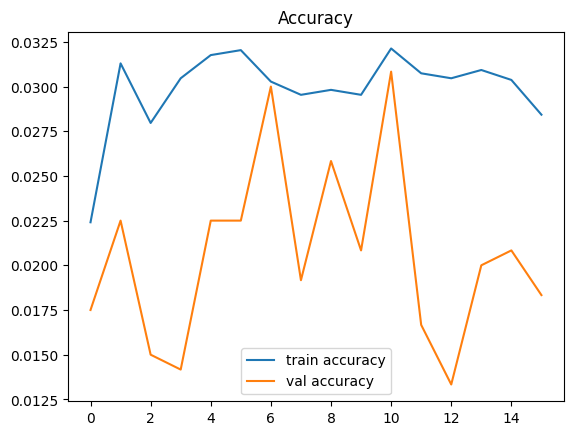

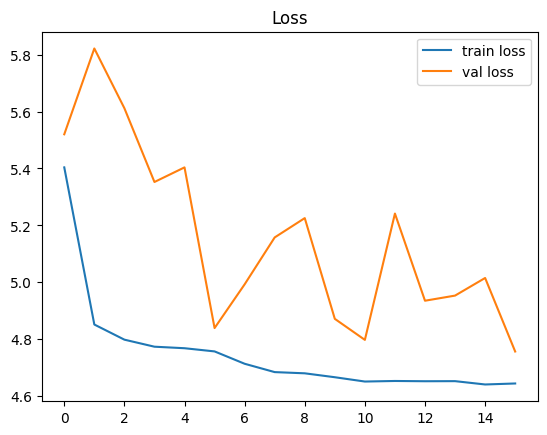

In [6]:
# ==========================================
# MLP model (CONFIG'e göre) (by CONFIG)
# ==========================================

def build_mlp(input_dim, num_classes, config):
    inputs = keras.Input(shape=(input_dim,))
    x = inputs

    for units in config["HIDDEN_LAYERS"]:
        x = layers.Dense(
            units,
            activation=None,
            kernel_regularizer=keras.regularizers.l2(config["L2"]),
            use_bias=False,
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.Dropout(config["DROPOUT"])(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    return model

model = build_mlp(input_dim, num_classes, CONFIG)
model.summary()

# ==========================================
# Compile
# ==========================================

opt = keras.optimizers.Adam(learning_rate=CONFIG["LEARNING_RATE"])


model.compile(
    optimizer=opt,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

callbacks = []
if CONFIG["EARLY_STOP"]:
    early_stop = keras.callbacks.EarlyStopping(
        monitor="val_accuracy",               # val_loss yerine val_accuracy
        patience=CONFIG["EARLY_STOP_PATIENCE"],
        mode="max",                           # en büyük val_accuracy'yi arıyoruz
        restore_best_weights=True,
    )


    callbacks.append(early_stop)

# ==========================================
# Training
# ==========================================

history = model.fit(
    x_train,
    y_train,
    batch_size=CONFIG["BATCH_SIZE"],
    epochs=CONFIG["EPOCHS"],
    validation_split=CONFIG["VAL_SPLIT"],
    callbacks=callbacks,
)


# ==========================================
# En iyi validation accuracy'ye göre epoch'u seç
# Select the epoch with best validation accuracy
# ==========================================

val_acc_history = history.history["val_accuracy"]
train_acc_history = history.history["accuracy"]

# En yüksek validation accuracy
best_val_acc = max(val_acc_history)

# Bu değerin hangi epoch'ta olduğunu bul (0-based index)
best_epoch_index = val_acc_history.index(best_val_acc)

# İnsan okunabilir epoch numarası (1-based)
best_epoch = best_epoch_index + 1

# Aynı epoch'taki train accuracy
best_train_acc = train_acc_history[best_epoch_index]

print(f"\nBest epoch (val_accuracy'ye göre): {best_epoch}")
print(f"Best val_accuracy: {best_val_acc:.4f}")
print(f"Train accuracy at best epoch: {best_train_acc:.4f}")

# ==========================================
# Test değerlendirme
# Test evaluation
# ==========================================

# test_loss, test_acc = model.evaluate(x_test, y_test)
# print(f"Test loss: {test_loss:.4f}")
# print(f"Test accuracy: {test_acc:.4f}")

# ==========================================
# Accuracy değerini results'a kaydet
# Save the accuracy value to results
# ==========================================

import csv
from datetime import datetime

os.makedirs("results", exist_ok=True)
csv_path = "results/results.csv"

write_header = not os.path.exists(csv_path)

with open(csv_path, "a", newline="") as f:
    writer = csv.writer(f)
    
    if write_header:
        writer.writerow([
            "timestamp",
            "config_id",
            "best_epoch",
            "best_val_accuracy",
            "train_accuracy_at_best_epoch",
        ])
    
    writer.writerow([
        datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        CONFIG["ID"],
        best_epoch,
        float(best_val_acc),
        float(best_train_acc),
    ])

print(f"\nSonuç kaydedildi → {csv_path}")

# ==========================================
# Örnek tahmin
# ==========================================

predictions = model.predict(x_test[:5])
pred_labels = predictions.argmax(axis=1)

print("Gerçek label'lar:", y_test[:5])
print("Tahmin label'lar:", pred_labels)

print("\nGerçek sınıf isimleri:")
for i in range(5):
    print(i, "->", class_names[y_test[i]])

print("\nTahmin sınıf isimleri:")
for i in range(5):
    print(i, "->", class_names[pred_labels[i]])


# ==========================================
# Eğitim grafikleri
# Training graphics
# ==========================================

plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="val accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.title("Loss")
plt.show()
